<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Foxp2"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/Foxp2/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


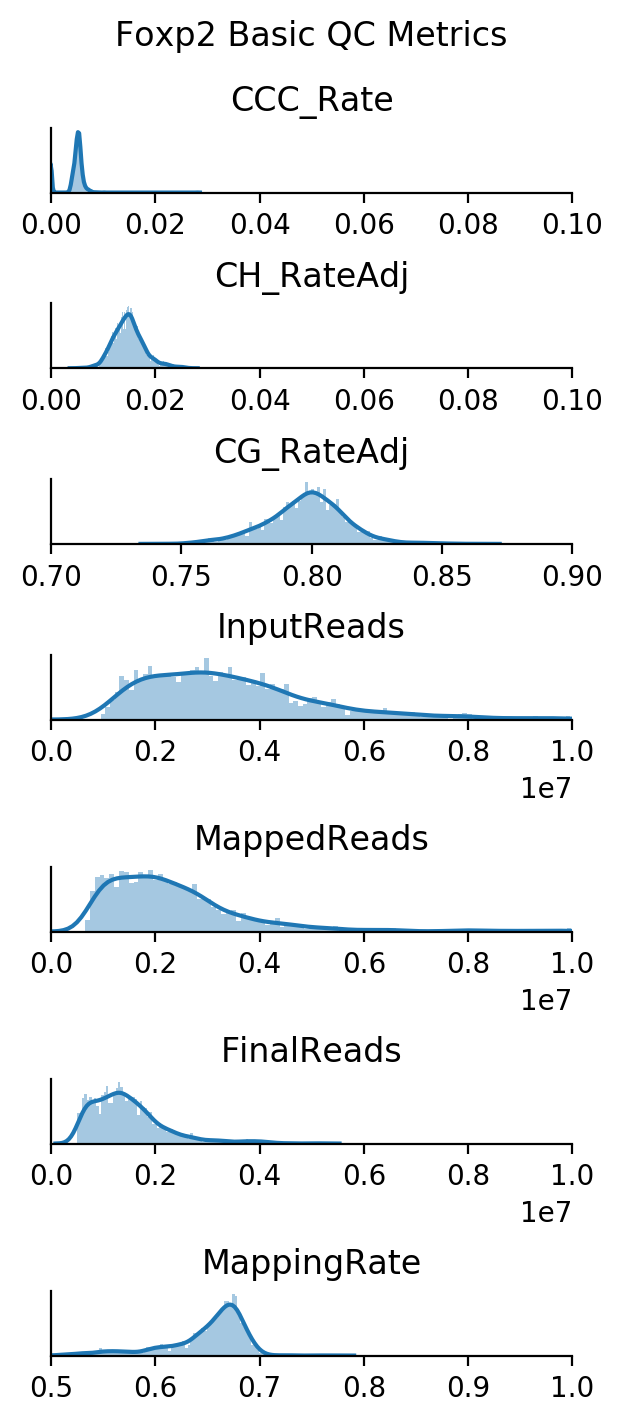

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

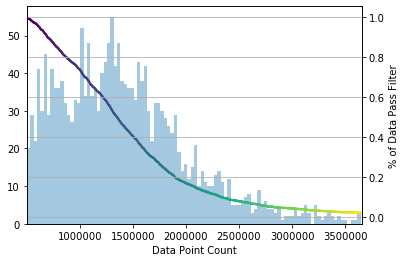

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1964/1964 (100.0%)
CG_RateAdj passed 1964/1964 (100.0%)
CH_RateAdj passed 1964/1964 (100.0%)
FinalReads passed 1964/1964 (100.0%)
MappingRate passed 1964/1964 (100.0%)
Overall passed 1964/1964 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 63
171219 92
180109 137
180110 233
180111 92
180119 2
180208 11
180212 14
180220 25
180222 41
180320 25
180326 6
180329 41
180402 38
180403 11
180405 169
180417 1
180430 1
180501 2
180724 13
180806 49
180911 101
180917 18
180925 58
181002 2
181008 13
181009 11
181015 103
181016 133
181204 35
181206 39
181218 94
181220 275
190122 1
190124 1
190205 1
190207 12
190212 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 207 53.9%
ad002 251 65.4%
ad004 238 62.0%
ad006 276 71.9%
ad007 237 61.7%
ad008 244 63.5%
ad010 265 69.0%
ad012 246 64.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
1B_M_1039,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.005570,0.774750,0.773490,0.015830,0.010320,667833.0,1370474,899948.0,1B,...,9.347657,-0.269971,31.837522,-15.501479,Foxp2,-1.834257,1.476008,-42.413403,24.767326,True
1B_M_527,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.007140,0.784850,0.783300,0.024870,0.017860,1646095.0,3865938,2424056.0,1B,...,12.813566,-0.765040,42.911572,-16.317718,Foxp2,4.314596,-1.809923,-11.762243,50.245208,True
1C_M_1073,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.004590,0.781470,0.780460,0.010290,0.005730,1872313.0,4110428,2770789.0,1C,...,9.380395,-0.327169,31.876384,-15.463794,Foxp2,-1.997689,1.644531,-42.679251,24.947972,True
1C_M_1258,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.004750,0.783230,0.782200,0.013700,0.008990,1411578.0,3142710,2112043.0,1C,...,9.277886,-0.326585,31.632483,-15.387916,Foxp2,-1.992971,2.269694,-43.205551,25.505552,True
1C_M_1351,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.004230,0.784220,0.783300,0.012150,0.007950,1919182.0,4437606,2954002.0,1C,...,9.214546,-0.371431,31.731582,-15.367732,Foxp2,-2.054185,2.192662,-43.125547,25.449403,True
1C_M_1421,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.004000,0.788650,0.787800,0.013600,0.009640,1157725.0,2541256,1668030.0,1C,...,9.257171,-0.431975,31.600908,-15.363829,Foxp2,-1.966189,2.234949,-43.209688,25.524672,True
1C_M_1424,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.003620,0.786580,0.785800,0.010460,0.006860,1114502.0,2484696,1608278.0,1C,...,9.473711,-0.060300,31.478603,-15.610204,Foxp2,-1.438860,0.640202,-42.141152,23.707459,True
1C_M_1487,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.003940,0.779570,0.778700,0.009370,0.005450,1226710.0,2739760,1811395.0,1C,...,9.501528,-0.051501,31.448523,-15.704936,Foxp2,-1.426091,0.509655,-42.078298,23.587468,True
1C_M_1490,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180212_1C...,0.004200,0.807950,0.807140,0.012560,0.008400,1028547.0,2219408,1464514.0,1C,...,9.512911,-0.139944,31.491342,-15.634082,Foxp2,-1.652895,0.535187,-42.129428,23.716676,True
